In [1]:
# Model Training

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

#saving the trained model
import joblib

In [3]:
RESOURCE_FOLDER = '../resources'
DATA_FOLDER = f'{RESOURCE_FOLDER}/data'
MODEL_FOLDER = f'{RESOURCE_FOLDER}/models'

FEATURES_FILE = 'bimbas_features.csv'
MODEL_NAME = 'bimbas_model.joblib'

RAND_SEED = 42

# 1 - Load training data

In [4]:
df_features = pd.read_csv(f"{DATA_FOLDER}/{FEATURES_FILE}")
df_train = df_features.copy()
df_train = df_train[df_train['dataset'] == 'train']

df_train.drop(columns=['dataset'], inplace=True)
df_train.set_index('contributor', inplace=True)
df_train.head()

,label,DAAR_IQR,DAAR_gini,DAAR_mean,DAAR_median,DAAR_std,DCAR_IQR,DCAR_gini,DCAR_mean,DCAR_median,...,NCAR_median,NCAR_std,NOR,NT,NTR_IQR,NTR_gini,NTR_mean,NTR_median,NTR_std,ORR
contributor,,,,,,,,,,,,,,,,,,,,,
kaczmarj,Human,44.184,0.593,43.242,22.819,52.922,8.141,0.641,95.446,1.495,...,1.5,1.838,7,9,2.0,0.333,2.0,1.0,1.414,0.778
plasmapy-requirements-bot[bot],Bot,NaN,0.000,NaN,NaN,0.000,0.000,0.000,2016.001,2016.001,...,27.0,0.000,1,3,0.0,0.000,3.0,3.0,0.000,1.000
accesslint[bot],Bot,18.982,0.602,17.468,10.234,23.272,0.000,0.780,2.276,0.000,...,2.0,4.348,27,1,0.0,0.000,1.0,1.0,0.000,1.000
blueztestbot,Bot,4.886,0.754,7.880,2.066,15.637,2.969,0.752,6.927,0.358,...,5.0,12.241,2,6,1.5,0.208,3.0,3.5,1.414,0.500
thundernest-bot,Bot,NaN,0.000,NaN,NaN,0.000,0.000,0.000,1193.347,1193.347,...,300.0,0.000,1,1,0.0,0.000,1.0,1.0,0.000,1.000


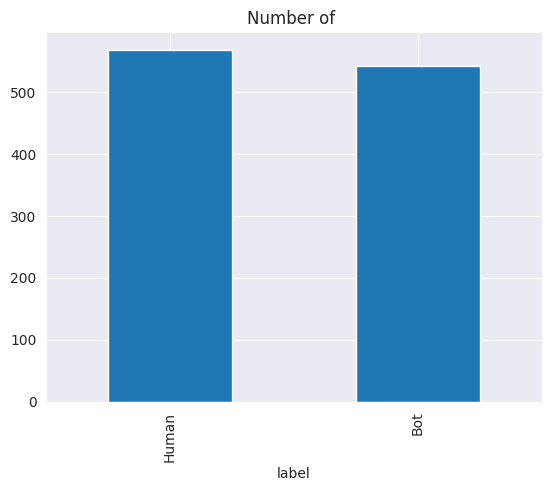

In [5]:
# Plot the balance of bot and human
df_train['label'].value_counts().plot(kind='bar')
plt.title("Number of ")
plt.show()

We can see that the number of bots and humans is balanced.

# 2 - Load the model
The model is the BIMBAS model which is a GradientBoostingClassifier with the following parameters :
- criterion='friedman_mse'
- loss='log_loss'
- learning_rate=0.05
- max_depth=3
- max_features='log2'
- n_estimators=100

In [6]:
def make_nested_imputers(df):
    """
    args: df - DataFrame; contributor behavioural features

    returns: preprocessor - ColumnTransformer that specifies all the indicator, imputers

    method: Define all the individual indicator and imputers and give it to the column transformer
            in the form of list of tuples. Each tuple is of the form
            ('transformer name', 'transformer', 'column names')
    """

    #indicator and imputer
    imputers = {'nan_indicator': MissingIndicator(missing_values=np.nan, features='all'),
                'nan_imputer': SimpleImputer(missing_values=np.nan, strategy='median',
                                             keep_empty_features=True)
                }

    #names for indicator and imputers
    imputer_names = {'nan_indicator': 'indicate_nan',
                     'nan_imputer': 'impute_nan'
                     }

    #group of columns to be used in indicator and imputers

    nan_col_names = df.columns[df.isna().any()].to_list()

    nested_transformers = [(imputer_names[imputer], imputers[imputer], nan_col_names)
                           for imputer in imputers]
    preprocessor = ColumnTransformer(transformers=nested_transformers,
                                     remainder='passthrough',
                                     verbose_feature_names_out=False, force_int_remainder_cols=False)
    return preprocessor

def make_custom_pipeline(df, clf=None, with_clf=True):
    """
    args: df - DataFrame; contributor behavioural features
          clf - method; classifier to be used
          with_clf - bool; To include the estimator (classifier) in the pipeline
                           (True) or just the data transformation

    returns: pipe - Pipeline of transformers to be applied on the data

    method: invoke make_nested_imputers for getting all the transformations that has to applied on
            the data and build the pipeline with nested transformations and classifier
    """

    preprocessor = make_nested_imputers(df)
    if with_clf:
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('clf', clf)
        ])
    else:
        pipe = Pipeline([
            ('preprocessor', preprocessor)])

    return pipe

In [7]:
model = GradientBoostingClassifier(random_state=RAND_SEED,
                                   criterion='friedman_mse',
                                   loss='log_loss',
                                   learning_rate=0.05,
                                   max_depth=3,
                                   max_features='log2',
                                   n_estimators=100)

# 3 - Train the model

In [8]:
label_map = {
    'Bot': 1,
    'Human': 0
}

# Create a new DataFrame without modifying the original df_train
df_train_processed = df_train.copy()
df_label = df_train_processed['label'].apply(lambda x: label_map[x]).values
df_train_processed = df_train_processed.drop(columns=['label'])
# Use the processed DataFrame
pipe = make_custom_pipeline(df_train_processed, model)
pipe.fit(df_train_processed, df_label)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('indicate_nan',
                                                  MissingIndicator(features='all'),
                                                  ['DAAR_IQR', 'DAAR_mean',
                                                   'DAAR_median', 'DCAT_IQR',
                                                   'DCAT_mean',
                                                   'DCAT_median']),
                                                 ('impute_nan',
                                                  SimpleImputer(keep_empty_features=True,
                                                                strategy='median'),
                                                  ['DAAR_IQR', 'DAAR_mean',
                                                   'DAAR_median', 'DCAT_IQR',
                                                   'DCAT_mean',
                                                   'DCAT_median'])],
                                   verbose_feature_names_out=False)),
                ('clf',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            max_features='log2',
                                            random_state=42))])

# 4 - Save the model

In [9]:
joblib.dump(pipe, f"{MODEL_FOLDER}/{MODEL_NAME}")

['../resources/models/bimbas_model.joblib']

# 5 - Test model

<Axes: xlabel='label'>

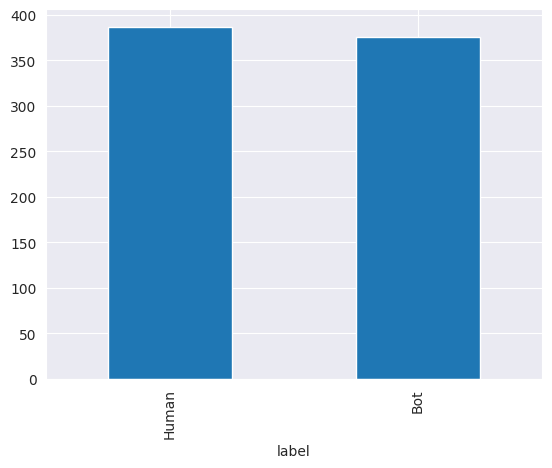

In [10]:
model = joblib.load(f"{MODEL_FOLDER}/{MODEL_NAME}")

df_test = df_features.copy()
df_test = df_test[df_test['dataset'] == 'test']
df_test.set_index('contributor', inplace=True)
df_test.drop(columns=['dataset'], inplace=True)

df_test['label'].value_counts().plot(kind='bar')

In [11]:
df_test_processed = df_test.copy()

df_test_label = df_test_processed['label'].apply(lambda x: label_map[x]).values
df_test_processed = df_test_processed.drop(columns=['label'])
df_test_processed.head()

,DAAR_IQR,DAAR_gini,DAAR_mean,DAAR_median,DAAR_std,DCAR_IQR,DCAR_gini,DCAR_mean,DCAR_median,DCAR_std,...,NCAR_median,NCAR_std,NOR,NT,NTR_IQR,NTR_gini,NTR_mean,NTR_median,NTR_std,ORR
contributor,,,,,,,,,,,,,,,,,,,,,
otc-zuul[bot],1.575,0.920,7.543,0.357,36.369,0.002,0.970,0.389,0.001,2.398,...,3.0,1.043,4,5,1.0,0.077,3.569,4.0,0.575,0.078
ljharb,0.338,0.849,0.800,0.068,2.308,0.000,0.867,0.382,0.000,2.558,...,1.0,0.988,31,15,1.0,0.293,1.698,1.0,1.085,0.360
juancarlospaco,3.347,0.853,8.808,0.241,22.710,0.000,0.878,1.934,0.000,13.118,...,1.0,3.644,18,12,1.0,0.250,1.659,1.0,0.825,0.439
tldr-bot,NaN,0.000,NaN,NaN,0.000,0.000,0.000,1398.548,1398.548,0.000,...,300.0,0.000,1,1,0.0,0.000,1.000,1.0,0.000,1.000
jakirkham,0.327,0.952,3.244,0.077,28.496,0.000,0.741,0.046,0.000,0.201,...,1.0,1.267,15,12,1.0,0.291,1.740,1.0,1.080,0.205


In [20]:
from rabbit import compute_confidence
import warnings


def predict(features, model):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        proba = model.predict_proba(features)
    return compute_confidence(proba[0][1])

In [23]:
# Create a df with 4 column but with the "contributor" column as index
df_prediction = pd.DataFrame(columns=['true_bot', 'predicted_bot'])
df_prediction = df_prediction.astype(int)

for contributor in df_test.index:
    true_bot = df_test.loc[contributor, 'label']
    y_prediction, confidence = predict(df_test_processed.loc[[contributor]], model)
    new_row = pd.DataFrame([{
        'contributor': contributor,
        'true_bot': true_bot,
        'predicted_bot': y_prediction,
        'confidence': confidence
    }])
    # Set true_bot and predicted_bot as int
    new_row.set_index('contributor', inplace=True)
    df_prediction = pd.concat([df_prediction, new_row], ignore_index=False)

df_prediction.index.name = 'contributor'
display(df_prediction)

,true_bot,predicted_bot,confidence
contributor,,,
otc-zuul[bot],Bot,Bot,0.807
ljharb,Human,Human,0.777
juancarlospaco,Human,Human,0.785
tldr-bot,Bot,Bot,0.865
jakirkham,Human,Human,0.772
...,...,...,...
mmstick,Human,Human,0.882
asyncapi-bot,Bot,Human,0.870
jeffgbutler,Human,Human,0.794


In [24]:

df_prediction.to_csv(f"{RESOURCE_FOLDER}/evals/bimbas_predictions.csv", index=True)